# K-means clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import rasterio
from rasterio.plot import plotting_extent, show, show_hist, reshape_as_image
import xarray as xr

## Importing the data using xarray

In [2]:
vars_vec = np.array(['HCP1QP', 'PRP1QP', 'HCP2QP', 'PRP2QP', 'HCP4QP', 'PRP4QP'], dtype=np.dtype(object))

raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=("band", [vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer.squeeze()
    i += 1

## K-means clustering

For the implementation of K-means, the tools available through the scikit-learn Python library are used [(Pedregosa et al., 2011)](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html).

First, the data is extracted from the xarray dataset. Then the data is standardized which means the clustering procedure will not be influenced by differences in variance of the original variables.

In [3]:
df_raster = stack_data.to_dataframe()[vars_vec]
df_raster.shape

(27540, 6)

In [4]:
from sklearn import preprocessing as prep

rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[~rows_with_nan]
df_std = pd.DataFrame(prep.StandardScaler().fit_transform(df_nona))

Implementation with k=4 (aribitrarily for now)

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0, n_init=5, init='k-means++').fit(df_std)

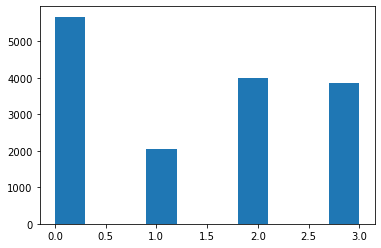

In [49]:
clusters = kmeans.predict(df_std)
kmeans.cluster_centers_
plt.hist(clusters)
plt.show()

In [50]:
cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = clusters

df_raster['kmeans4'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
#stack_array1 = stack_data.to_array()

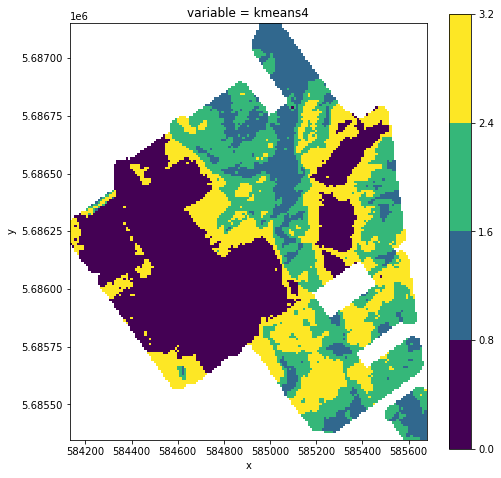

In [51]:
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='kmeans4').plot.pcolormesh(figsize=(8,8), levels=5)
ax.axes.set_aspect('equal')

## How to decide on the number of clusters?

* 'Elbow' method = look how within cluster variability decreases with increasing number of clusters

    Cost function in k-means is a sum of squared distances for each observations to its cluster center (inertia). This will become smaller with increasing nr of clusters, but the gain will become smaller and smaller. From this an 'optimum' can be derived.

* Use information criteria such as AIC/ BIC

    Likelihood-based approach. It sees the clusters as having an identical spherical Gaussian distribution [(Fraley, 1998)](https://doi.org/10.1093/comjnl/41.8.578)\
    Computation of BIC for kmeans classification: [(Pelleg & Moore, 2002)](https://web.cs.dal.ca/~shepherd/courses/csci6403/clustering/xmeans.pdf), although Pelleg & Moore use the unbiased estimator for the variance instead of the maximum-likelihood estimator that should actually be used for the calculation of the BIC as is pointed out [here](https://github.com/bobhancock/goxmeans/blob/master/doc/BIC_notes.pdf). Therefore the BIC as implemented below will use the maximum-likelihood estimator.
    
* Davies-Bouldin score

    Heuristically developed indicator of the average 'similarity' between clusters, should be low [(Davies & Bouldin, 1979)](https://ieeexplore.ieee.org/document/4766909).
  
    
    **Calculation**:\
    $R_{ij}=\frac{s_i+s_j}{d_{ij}}$ 
    With s_{i} the standard deviation of the distance samples in cluster i to the cluster center and $d_{ij}$ the Euclidean distance between the centers of cluster i and j.\
    For each cluster i, the its smallest $R_{ij}$ is determined (the similarity to the most nearby cluster) and denoted $R_{i}$.\
    The Davies-Bouldin score is then defined as $\bar{R} = \frac{1}{N}\sum_{i=1}^{N}{R_i}$.\
    It thus indicates the average of similarities of each cluster with its most similar cluster.

In [6]:
# Function for calculating the BIC from a kmeans clustering model

def BIC_kmeans(kmeans, data):
    
    k = kmeans.cluster_centers_.shape[0]
    r, m = data.shape
    var_mle = 1/(m*r)*kmeans.inertia_
    predict = kmeans.predict(data)
    Rn = np.unique(predict, return_counts = True)[1]
    logRn = np.log(Rn)
    
    logl = np.sum(Rn*logRn) - r*m/2*np.log(2*np.pi*var_mle) - m/2*(r-k)  - r*np.log(r)
    params = k + m*k
    BIC = -logl + params*np.log(r)/2
    
    return BIC

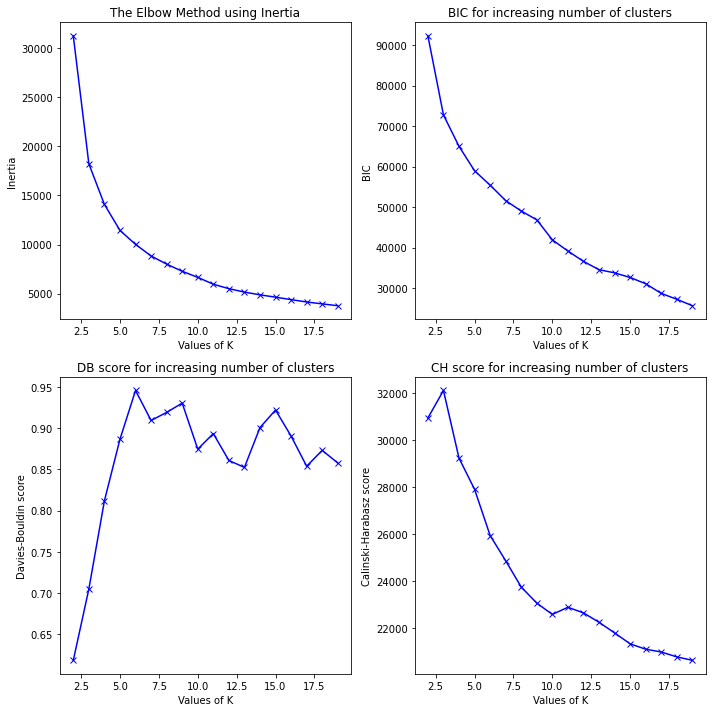

In [10]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

inertias = []
BIC = []
DB_scores = []
CH_scores = []
K = range(2, 20)

for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=5, init='k-means++').fit(df_std)
    
    inertias.append(kmeans.inertia_)
    BIC.append(BIC_kmeans(kmeans, df_std))
    DB_scores.append(davies_bouldin_score(df_std, kmeans.labels_))
    CH_scores.append(calinski_harabasz_score(df_std, kmeans.labels_))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10,10))

ax0.plot(K, inertias, 'bx-')
ax0.set_xlabel('Values of K')
ax0.set_ylabel('Inertia')
ax0.set_title('The Elbow Method using Inertia')

ax1.plot(K, BIC, 'bx-')
ax1.set_xlabel('Values of K')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for increasing number of clusters')

ax2.plot(K, DB_scores, 'bx-')
ax2.set_xlabel('Values of K')
ax2.set_ylabel('Davies-Bouldin score')
ax2.set_title('DB score for increasing number of clusters')

ax3.plot(K, CH_scores, 'bx-')
ax3.set_xlabel('Values of K')
ax3.set_ylabel('Calinski-Harabasz score')
ax3.set_title('CH score for increasing number of clusters')

plt.tight_layout()
plt.show()


**No minimum for the BIC? Is this an indication that there are no spherical clusters?**

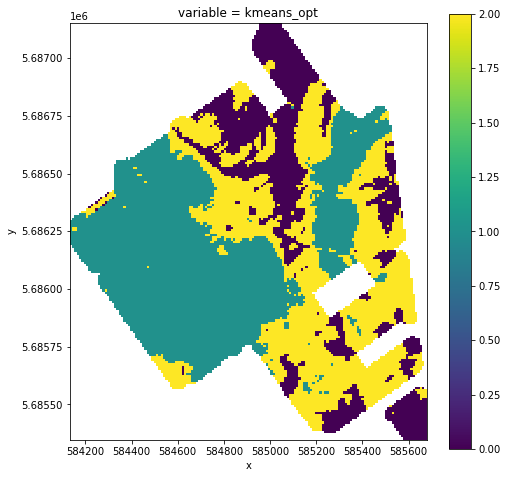

In [11]:
optimal_n = 3 # As derived from the CH-score

kmeans = KMeans(n_clusters=optimal_n, random_state=0, n_init=5, init='k-means++').fit(df_std)
clusters = kmeans.predict(df_std)
cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = clusters

df_raster['kmeans_opt'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')

cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='kmeans_opt').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

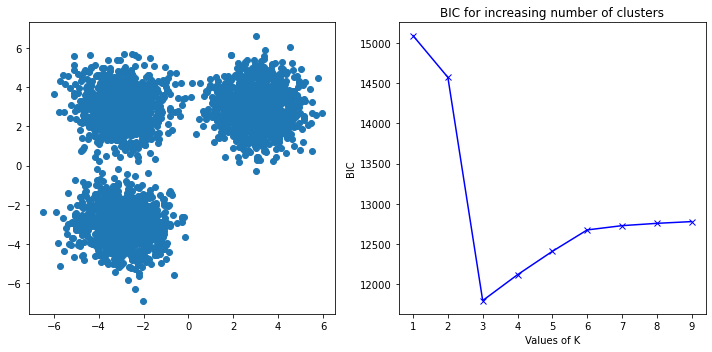

In [55]:
## Test for clearly clustered data, does the BIC function work correctly and how does the BIC indicate the nr of clusters?
from numpy.random import multivariate_normal as rnorm
centers = np.array([[3,3],[-3,3],[-3,-3]])
cov = np.array([[1,0],[0,1]])
x1 = rnorm(centers[0], cov, size=1000)
x2 = rnorm(centers[1], cov, size=1000)
x3 = rnorm(centers[2], cov, size=1000)
x  = np.array([row for row_group in zip(x1, x2, x3) for row in row_group])

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
ax0.scatter(x=x[:,0], y=x[:,1])

BIC = []
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=5, init='k-means++').fit(x)
    
    BIC.append(BIC_kmeans(kmeans, x))

ax1.plot(K, BIC, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('BIC')
plt.title('BIC for increasing number of clusters')
plt.tight_layout()
plt.show()

# Works perfectly when with spherical gaussians of equal size, EMI data are not spherical gaussians! some variables are strongly correlated.

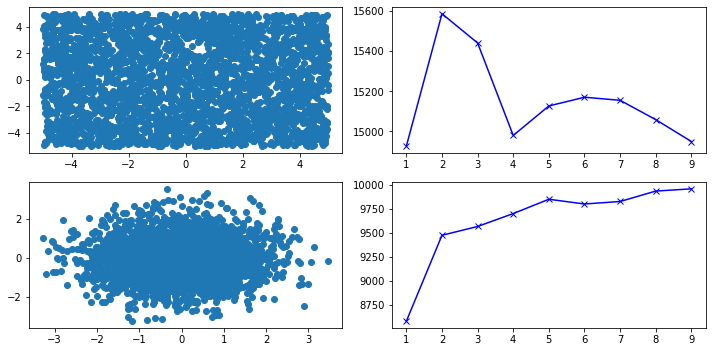

In [56]:
# What if the distributions is more uniform or just one cluster

from numpy.random import uniform as uni

y1 = uni(low=-5, high = 5, size = 3000)
x1 = uni(low=-5, high=5, size=3000)

x_uni = np.stack((x1, y1), axis=1)
x_sph = rnorm((0,0), [[1,0],[0,1]], size=3000)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10,5))
ax0.scatter(x=x_uni[:,0], y=x_uni[:,1])
ax2.scatter(x=x_sph[:,0], y=x_sph[:,1])

BIC_uni = []
BIC_sph=[]
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeans_uni = KMeans(n_clusters=k, random_state=0, n_init=5, init='k-means++').fit(x_uni)
    kmeans_sph = KMeans(n_clusters=k, random_state=0, n_init=5, init='k-means++').fit(x_sph)
    
    BIC_uni.append(BIC_kmeans(kmeans_uni, x_uni))
    BIC_sph.append(BIC_kmeans(kmeans_sph, x_sph))
    

ax1.plot(K, BIC_uni, 'bx-')
ax3.plot(K, BIC_sph, 'bx-')
plt.tight_layout()
plt.show()

### K-means with coordinates as additional variables

In [12]:
df_raster = stack_data.to_dataframe()[vars_vec]
df_xy = df_raster.reset_index()
rows_with_nan = df_xy.isnull().any(axis=1)
df_nona = df_xy[~rows_with_nan]
df_std = pd.DataFrame(prep.StandardScaler().fit_transform(df_nona))

(array([4829.,    0.,    0., 2130.,    0.,    0., 2774.,    0.,    0.,
        5839.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

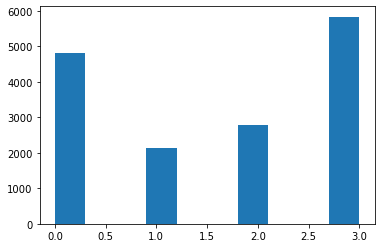

In [13]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=5, init='k-means++').fit(df_std)
clusters = kmeans.predict(df_std)
kmeans.cluster_centers_
plt.hist(clusters)

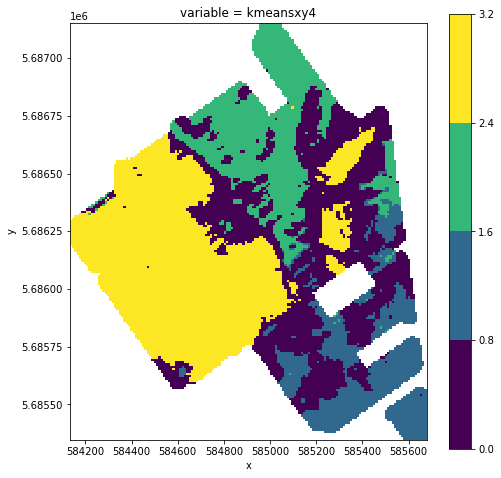

In [14]:
cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = clusters

df_raster['kmeansxy4'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')

cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='kmeansxy4').plot.pcolormesh(figsize=(8,8), levels=5)
ax.axes.set_aspect('equal')

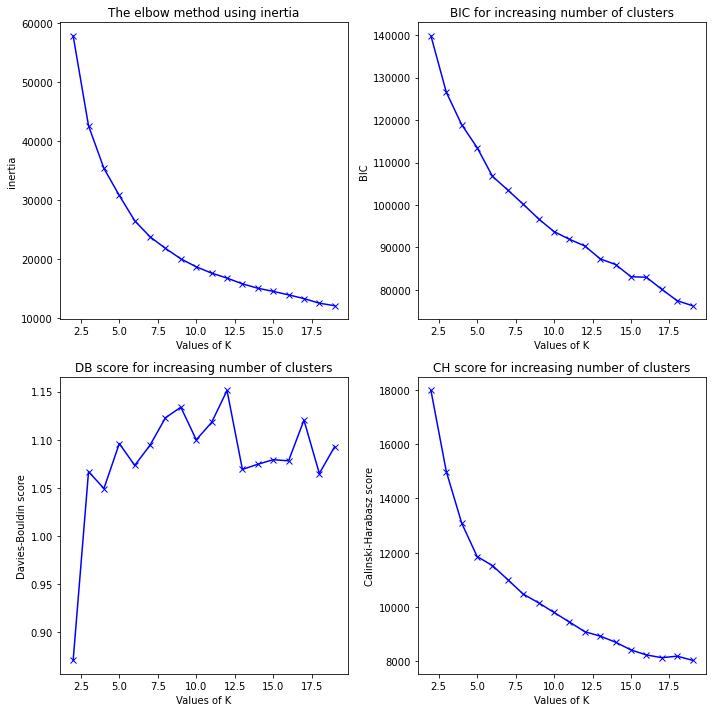

In [16]:
inertias = []
BIC = []
DB_scores = []
CH_scores = []
K = range(2, 20)

for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=5, init='k-means++').fit(df_std)
    
    inertias.append(kmeans.inertia_)
    BIC.append(BIC_kmeans(kmeans, df_std))
    DB_scores.append(davies_bouldin_score(df_std, kmeans.labels_))
    CH_scores.append(calinski_harabasz_score(df_std, kmeans.labels_))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10,10))

ax0.plot(K, inertias, 'bx-')
ax0.set_xlabel('Values of K')
ax0.set_ylabel('inertia')
ax0.set_title('The elbow method using inertia')

ax1.plot(K, BIC, 'bx-')
ax1.set_xlabel('Values of K')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for increasing number of clusters')

ax2.plot(K, DB_scores, 'bx-')
ax2.set_xlabel('Values of K')
ax2.set_ylabel('Davies-Bouldin score')
ax2.set_title('DB score for increasing number of clusters')

ax3.plot(K, CH_scores, 'bx-')
ax3.set_xlabel('Values of K')
ax3.set_ylabel('Calinski-Harabasz score')
ax3.set_title('CH score for increasing number of clusters')

fig.tight_layout()
plt.show()

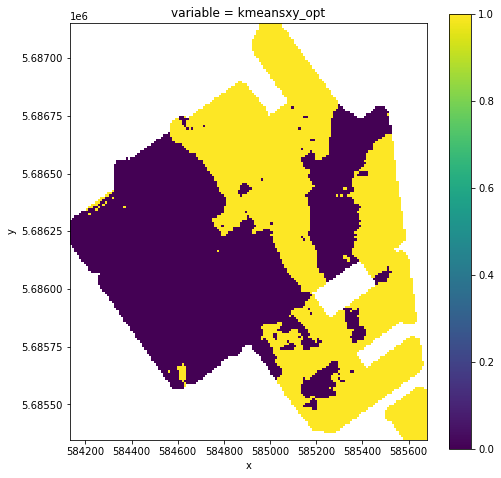

In [17]:
optimal_n = 2 # As derived from the DB-score

kmeans = KMeans(n_clusters=optimal_n, random_state=0, n_init=5, init='k-means++').fit(df_std)
clusters = kmeans.predict(df_std)

cl = np.empty((27540))
cl[:] = np.nan
cl[~rows_with_nan] = clusters

df_raster['kmeansxy_opt'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')

cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='kmeansxy_opt').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

### Discussion of K-means results (first impressions)

Groups according to the general trend: low EC - high EC.
No clear optimum for the number of clusters, according to the DB-score the optimal k is 2, for both the 'aspatial' and 'spatial' approach. The two different approaches result in roughly the same map.\
K-means is good at identifying clusters that have a spherical gaussian distribution, which clearly isn't the case here.

### References

* Davies, D. L., & Bouldin, D. W. (1979). A Cluster Separation Measure. IEEE Transactions on Pattern Analysis and Machine Intelligence, PAMI-1(2), 224–227. https://doi.org/10.1109/TPAMI.1979.4766909

* Fraley, C. (1998). How Many Clusters? Which Clustering Method? Answers Via Model-Based Cluster Analysis. The Computer Journal, 41(8), 578–588. https://doi.org/10.1093/comjnl/41.8.578

* Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12(85), 2825–2830.

* Pelleg, D., & Moore, A. (2000). X-means: Extending K-means with Efficient Estimation of the Number of Clusters. Seventeenth International Conference on Machine Learning, 727–734.